In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import ticker

In [36]:
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv(r'data\kaggle bank chrun\train.csv.zip')

## Exploratory Data Analysis

Description Of Features
These are all the columns as I understand them.

- ID columns
    - **id:** Unique identifier.
    - **CustomerId:** Customer identifier.
    - **Surname:** Customer last name.

- Categorical features
    - **Geography:** Customer location.
    - **Gender:** Gender of customer.
    - **HasCrCard:** Whether or not the customer has a credit card with the bank.
    - **IsActiveMember:** Whether or not the customer has active transactions with the bank.

- Numerical features
    - **CreditScore:** Measure of how reliable a customer is as a borrower.
    - **Age:** Age of customer.
    - **Tenure:** Amount of time customer has been doing business with the bank.
    - **Balance:** Amount of cash the customer has with the bank.
    - **NumOfProducts:** Number of products purchased by the customer.
    - **EstimatedSalary:** Rough salary of the customer.
    
- Result to predict against
    - **Exited:** Whether or not the customer has left the bank.

In [38]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [39]:
# check for null values

df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [40]:
# check for duplicated values for each column 

for name in df.columns.tolist():
    print(name, '-->', df.duplicated(subset=name).sum())
    print()

id --> 0

CustomerId --> 141813

Surname --> 162237

CreditScore --> 164577

Geography --> 165031

Gender --> 165032

Age --> 164963

Tenure --> 165023

Balance --> 134959

NumOfProducts --> 165030

HasCrCard --> 165032

IsActiveMember --> 165032

EstimatedSalary --> 109736

Exited --> 165032



In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


## Categorical Feature Analysis

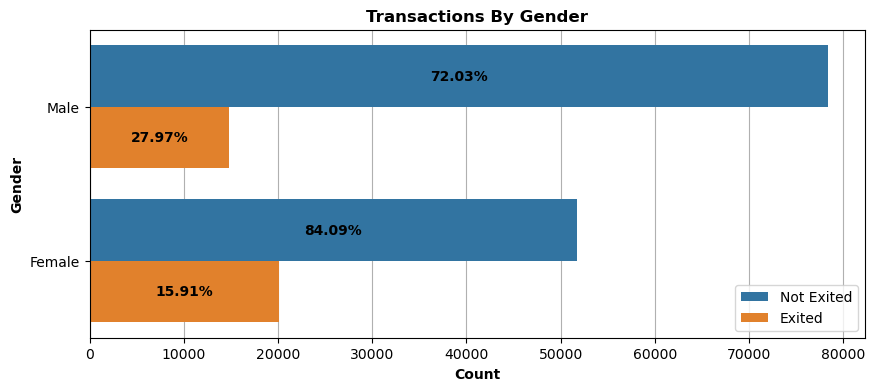

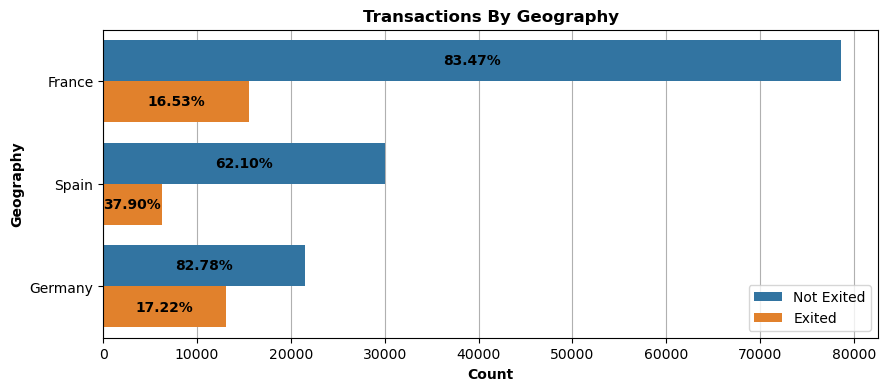

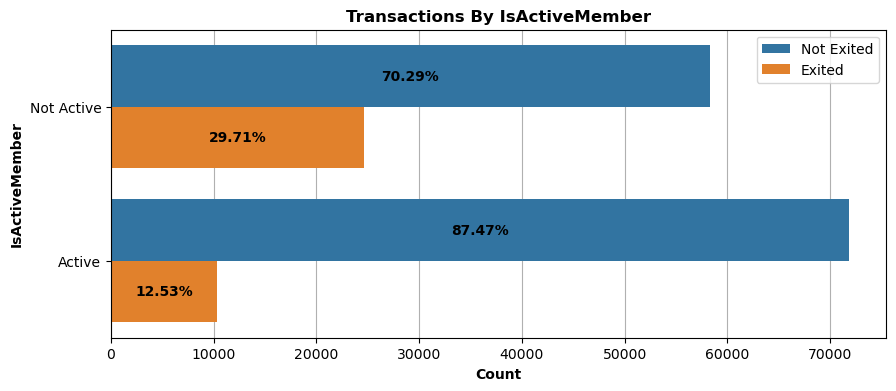

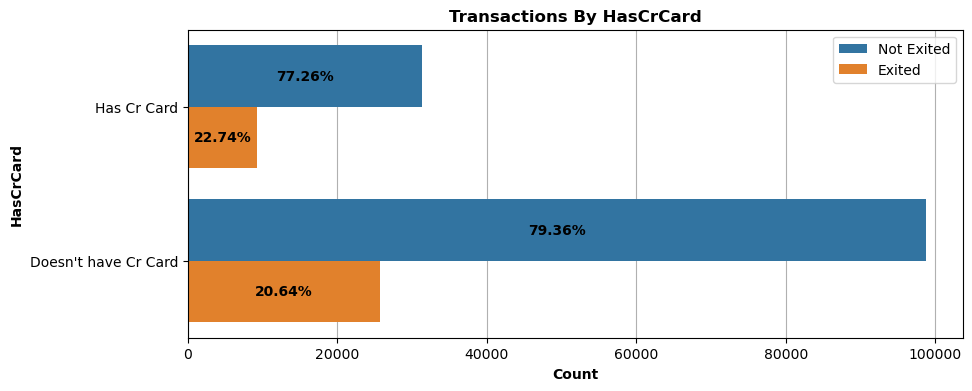

In [42]:
def plot_bar_plot(cat_value, cat_value_hue, custom_ylables=None):

    fig, ax = plt.subplots(figsize=(10,4))

    ax = sns.countplot(data=df, y=cat_value, hue=df[cat_value_hue].astype(str))

    # Labels to make the plot clearer
    ax.set_title(f'Transactions By {cat_value}', weight='bold')
    ax.set_ylabel(cat_value, weight='bold')
    ax.set_xlabel('Count', weight='bold')
    ax.grid(axis='x')
    ax.set_axisbelow(True)
    ax.legend(labels=[f'Not {cat_value_hue}', f'{cat_value_hue}'])

    # These 4 lines give the percentage labels ordered in this way:
    # First, the labels for the 1st bars in the hue.
    # After that, the labels for the 2nd bars in the hue.
    total_counts = df[cat_value].value_counts()
    hue_counts = df.groupby([cat_value, cat_value_hue]).size().unstack(fill_value=0)
    percentages = (hue_counts.T / total_counts * 100).T.values.flatten()
    percentages = np.concatenate((percentages[::2], percentages[1::2]))

    # Add percentage labels to the bars
    for patch, percentage in zip(ax.patches, percentages):
        width = patch.get_width()
        height = patch.get_height()
        x, y = patch.get_xy()
        
        # Add percentage label at the center of the bar
        ax.text(x + width / 2, y + height / 2, f'{percentage:.2f}%',
                ha='center', va='center', fontsize=10, color='black', weight='bold')
    
    if custom_ylables:
        ax.set_yticklabels(custom_ylables)

    plt.show()

plot_bar_plot('Gender', 'Exited')
plot_bar_plot('Geography', 'Exited')
plot_bar_plot('IsActiveMember', 'Exited', ['Not Active', 'Active'])
plot_bar_plot('HasCrCard', 'Exited', ['Has Cr Card', "Doesn't have Cr Card"])

### Numerical Feature Analysis

In [43]:
num_fea = ['CreditScore','Age','Tenure','Balance','EstimatedSalary', 'NumOfProducts']
df[num_fea].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,112574.822734,1.554455
std,80.103340,8.867205,2.806159,62817.663278,50292.865585,0.547154
min,350.000000,18.000000,0.000000,0.000000,11.580000,1.000000
25%,597.000000,32.000000,3.000000,0.000000,74637.570000,1.000000
50%,659.000000,37.000000,5.000000,0.000000,117948.000000,2.000000
75%,710.000000,42.000000,7.000000,119939.517500,155152.467500,2.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,4.000000


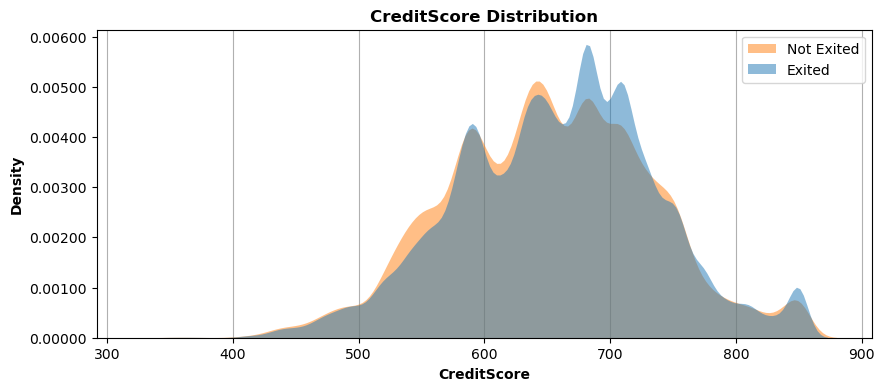

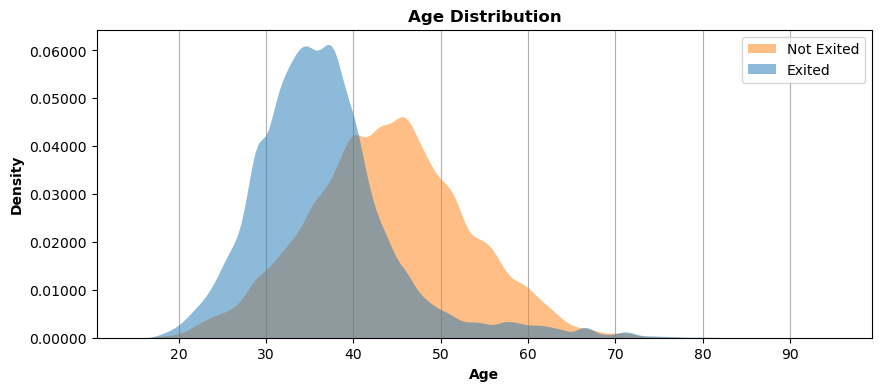

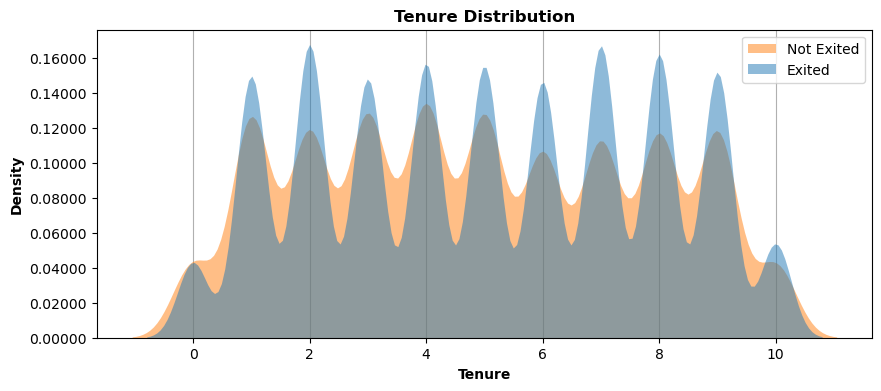

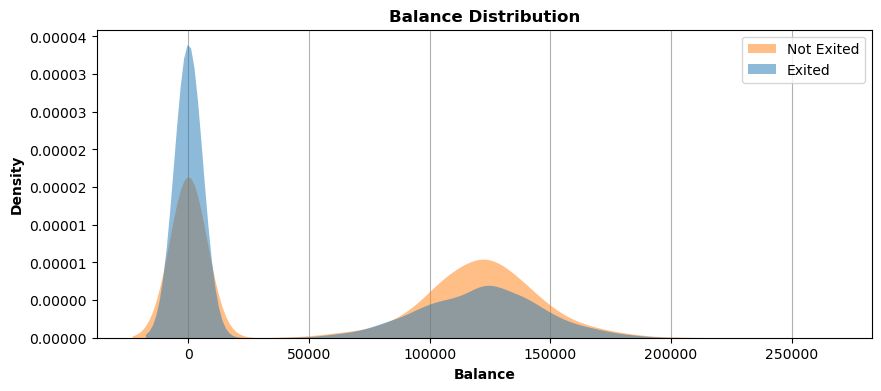

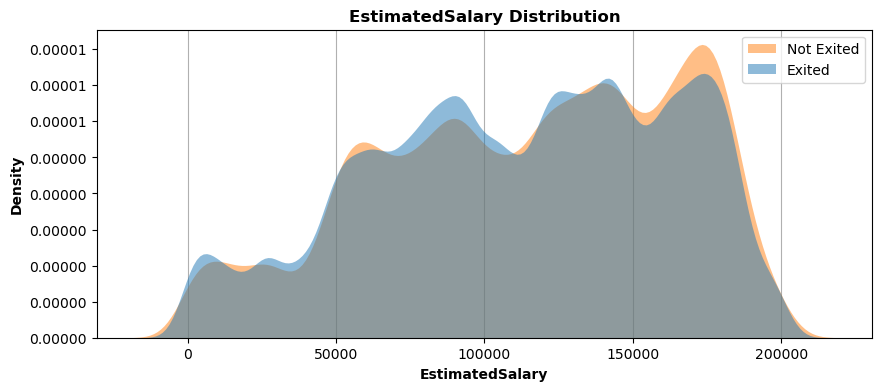

In [44]:
def plot_distribution(main_feat, hue_feat): 
    fig, ax = plt.subplots(figsize=(10,4))

    sns.kdeplot(data=df, x=main_feat, hue=hue_feat, fill=True,
                alpha=0.5, common_norm=False,linewidth=0, ax=ax)

    ax.set_title(f'{main_feat} Distribution', weight='bold')
    ax.set_ylabel('Density', weight='bold')
    ax.set_xlabel(main_feat, weight='bold')
    ax.grid(axis='x')
    ax.set_axisbelow(True)
    ax.legend(labels=[f'Not {hue_feat}', f'{hue_feat}'])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.5f"))

    plt.show()

plot_distribution('CreditScore', 'Exited')
plot_distribution('Age', 'Exited')
plot_distribution('Tenure', 'Exited')
plot_distribution('Balance', 'Exited')
plot_distribution('EstimatedSalary', 'Exited')

### ANOVA Tests

In [45]:
from scipy.stats import f_oneway


def anova_tests(data):
    '''
    This function performs an ANOVA test based on the dtype of the feature
    '''

    if df[data].dtype == 'object':
        values = df[data].unique()
        data_for_anova = [df.loc[df[data]==x, 'Exited'] for x in values]
        print(data)
        print(f_oneway(*data_for_anova))
        print()
    
    elif len(df[data].unique()) < 5:
        values = df[data].unique()
        data_for_anova = [df.loc[df[data]==x, 'Exited'] for x in values]
        print(data)
        print(f_oneway(*data_for_anova))
        print()    

    else:
        cut_df = pd.cut(df[data], 5, labels=[0, 1,2,3,4])
        data_for_anova = [df.loc[cut_df==n, 'Exited'] for n in range(5)]
        print(data)
        print(f_oneway(*data_for_anova))      
        print()

In [46]:
# This print the ANOVA results in an easy-to-view way

for x in ['CreditScore', 'Geography', 'Gender',
          'Age', 'Tenure', 'Balance', 'NumOfProducts',
          'HasCrCard', 'IsActiveMember', 'EstimatedSalary']:
    anova_tests(x)

CreditScore
F_onewayResult(statistic=56.31199433301987, pvalue=1.500568054485712e-47)

Geography
F_onewayResult(statistic=3850.9807436328238, pvalue=0.0)

Gender
F_onewayResult(statistic=3616.693181457038, pvalue=0.0)

Age
F_onewayResult(statistic=5818.6669417251915, pvalue=0.0)

Tenure
F_onewayResult(statistic=33.27843196929977, pvalue=8.623768939224358e-28)

Balance
F_onewayResult(statistic=855.3927221440127, pvalue=0.0)

NumOfProducts
F_onewayResult(statistic=11791.215114460987, pvalue=0.0)

HasCrCard
F_onewayResult(statistic=80.94474386262738, pvalue=2.3448985511987807e-19)

IsActiveMember
F_onewayResult(statistic=7631.6661912359805, pvalue=0.0)

EstimatedSalary
F_onewayResult(statistic=23.227472848226427, pvalue=3.210648076124843e-19)



### Data preparation

In [47]:
# This is the dataframe we should use to make predictions
# So, we have to make the same transformations as the dataframe for training the model.

df_test = pd.read_csv(r'data\kaggle bank chrun\test.csv.zip')

In [48]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Geography'], dtype=float)], axis=1)
df_test['Gender'] = df_test['Gender'] == 'Male'
df_test['Gender'] = df_test['Gender'].astype(float)

df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
0,165034,15773898,Lucchese,586,France,0.0,23.0,2,0.00,2,0.0,1.0,160976.75,1.0,0.0,0.0
1,165035,15782418,Nott,683,France,0.0,46.0,2,0.00,1,1.0,0.0,72549.27,1.0,0.0,0.0
2,165036,15807120,K?,656,France,0.0,34.0,7,0.00,2,1.0,0.0,138882.09,1.0,0.0,0.0
3,165037,15808905,O'Donnell,681,France,1.0,36.0,8,0.00,1,1.0,0.0,113931.57,1.0,0.0,0.0
4,165038,15607314,Higgins,752,Germany,1.0,38.0,10,121263.62,1,1.0,0.0,139431.00,0.0,1.0,0.0


In [49]:
df = pd.concat([df, pd.get_dummies(df['Geography'], dtype=float)], axis=1)
df['Gender'] = df['Gender'] == 'Male'
df['Gender'] = df['Gender'].astype(float)

df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,0,15674932,Okwudilichukwu,668,France,1.0,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,1.0,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,0.0,0.0
2,2,15694510,Hsueh,678,France,1.0,40.0,10,0.00,2,1.0,0.0,184866.69,0,1.0,0.0,0.0
3,3,15741417,Kao,581,France,1.0,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,1.0,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,0.0,1.0


In [50]:
unwanted = ['id', 'CustomerId', 'Surname', 'Geography', 'Exited']

predictors = [e for e in df.columns.tolist() if e not in unwanted]
predictors

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'France',
 'Germany',
 'Spain']

In [51]:
df_test_predictors = df_test[predictors]

In [52]:
X = df[predictors]
y = df['Exited']

## Model Training

Here, there has been trained 3 different models:
- Classification Tree
- Random Forest
- XGBoost Classifier

The process is the same. Specifically:
1) Fit the basic version of the model for a quick benchmark.
2) Tune the parameters with Gridsearch.
3) Train a model with the opimal parameters.

The tuning part is pretty long, so I've commented out all the code except for that of the best-performing model; XGBoost.

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=3, stratify=y)

### Classification Trees

In [54]:
# from sklearn.tree import DecisionTreeClassifier

# dtc_model = DecisionTreeClassifier(random_state=3, ccp_alpha=4e-5)
# dtc_model.fit(x_train, y_train)

In [55]:
# yhat = dtc_model.predict(x_test)
# metrics.accuracy_score(y_test, yhat)


In [56]:
# confusion_matrix = metrics.confusion_matrix(y_test, yhat)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Customer', 'Churn'])

# cm_display.plot()
# plt.show()

In [57]:
# There are way too many aplhas so I take a few at a time and then go deeper
# After try-and-error attempts I found that 4e-5 is the best value for alpha

# dtc_alphas = np.linspace(2e-5, 5.5e-5, 15)
# result_scores = []

# for alpha in dtc_alphas:
#     tree = DecisionTreeClassifier(random_state=3, ccp_alpha=alpha)
#     scores = cross_val_score(tree, X, y, cv=5)
#     result_scores.append([alpha, np.mean(scores), np.std(scores)])

# result_scores_df = pd.DataFrame(result_scores,
#                                 columns=['alpha', 'mean_acc', 'std'])

# result_scores_df.plot(x='alpha', y='mean_acc',
#                       yerr='std', marker='o', linestyle='--')

In [58]:
# tree = DecisionTreeClassifier(random_state=3, ccp_alpha=4e-5)
# cross_val_score(tree, X, y, cv=5).mean()

### Random forest

In [59]:
# # This grid search is the result of a LOT of try and error
# # with small_x and small_y so to 10x the process

# small_x = x_train.sample(frac=0.1)
# small_y = y_train.sample(frac=0.1)

# params = {
#     'max_depth': [50],
#     'min_samples_leaf': [2],
#     'n_estimators': [50,100],
#     'ccp_alpha': [3.4e-5],
#     'warm_start':[False],
#     'max_features':['sqrt']
# }

# rf_grid = GridSearchCV(estimator=RandomForestClassifier(),
#                        param_grid=params, cv=3, n_jobs=-1, verbose=1)

# rf_grid.fit(small_x, small_y)

In [60]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=50,
#                             n_estimators=50, oob_score=True, ccp_alpha= 3.4e-05,
#                             min_samples_leaf=2)
# rf.fit(x_train, y_train)

# cross_val_score(rf, X, y, cv=4).mean()

In [61]:
# imp_df = pd.DataFrame({
#     "Varname": X.columns,
#     "Imp": rf.feature_importances_
# })

# imp_df.sort_values(by="Imp", ascending=False)

### XGBoost

In [62]:
# The param tested are fruit of an iterative process

param_grid1 = {
    'max_depth':[5],
    'learning_rate': [0.15],
    'reg_lambda':[75],
    'gamma':[0.1],
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic'),
    param_grid=param_grid1,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    cv=2
)

optimal_params.fit(
    x_train,
    y_train,
    early_stopping_rounds=50,
    eval_metric='error',
    eval_set=[(x_test, y_test)],
    verbose=False
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1], 'learning_rate': [0.15],
                         'max_depth': [5], 'reg_lambda': [75]},
             scoring='accuracy', verbose=2)

In [63]:
print(optimal_params.best_score_)
print(optimal_params.best_params_)

0.8644595442517232
{'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 5, 'reg_lambda': 75}


In [64]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              gamma=0.1,
                              learning_rate=0.15,
                              max_depth=5,
                              reg_lambda=75,
                              )

xgb_model.fit(x_train,
              y_train,
              verbose=True,
              early_stopping_rounds=80,
              eval_metric='error',
              eval_set=[(x_test, y_test)])

[0]	validation_0-error:0.14061
[1]	validation_0-error:0.14058
[2]	validation_0-error:0.14027
[3]	validation_0-error:0.14036
[4]	validation_0-error:0.14067
[5]	validation_0-error:0.14046
[6]	validation_0-error:0.13830
[7]	validation_0-error:0.13839
[8]	validation_0-error:0.13573
[9]	validation_0-error:0.13564
[10]	validation_0-error:0.13567
[11]	validation_0-error:0.13564
[12]	validation_0-error:0.13637
[13]	validation_0-error:0.13597
[14]	validation_0-error:0.13585
[15]	validation_0-error:0.13597
[16]	validation_0-error:0.13582
[17]	validation_0-error:0.13549
[18]	validation_0-error:0.13537
[19]	validation_0-error:0.13473
[20]	validation_0-error:0.13482
[21]	validation_0-error:0.13500
[22]	validation_0-error:0.13470
[23]	validation_0-error:0.13452
[24]	validation_0-error:0.13455
[25]	validation_0-error:0.13415
[26]	validation_0-error:0.13385
[27]	validation_0-error:0.13379
[28]	validation_0-error:0.13394
[29]	validation_0-error:0.13367
[30]	validation_0-error:0.13340
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
print(metrics.accuracy_score(xgb_model.predict(x_test), y_test))
print(metrics.classification_report(xgb_model.predict(x_test), y_test))

0.8671796891568455


              precision    recall  f1-score   support

           0       0.95      0.89      0.92     27699
           1       0.57      0.74      0.64      5308

    accuracy                           0.87     33007
   macro avg       0.76      0.82      0.78     33007
weighted avg       0.89      0.87      0.87     33007



## Predicting the Values for the Test set given in competition

In [66]:
xgb_yhat = xgb_model.predict_proba(df_test_predictors)[:,1]
submission = pd.DataFrame(xgb_yhat, columns = ['Exited'])
submission.head()

,Exited
0,0.024253
1,0.793403
2,0.026572
3,0.238894
4,0.358487


In [67]:
id = df_test['id']

In [68]:
submission_final = pd.concat([id, submission], axis = 1)
submission_final.to_csv('submission.csv', index = False)